# Part 6. DEAP Dataset + LSTM

In this part 6, we shall start using deep learning techniques which is different from the traditional machine learning approaches in the sense that deep learning techniques are able to automatically learn useful features for the task.  In a more simple words, we can directly feed the raw data into deep learning model, and the model should be able to give reasonable accuracy.

*Note that we will be only predicting the valence.  Feel free to work on the arousal yourself.*

In this part, we shall explore LSTM which is a very common model for handling sequential data.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os
import pickle
import numpy as np

Set cuda accordingly.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## 1. Loading dataset

Let's first reuse the dataset loader we have created in Part 1.

In [3]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, path, stim):
        _, _, filenames = next(os.walk(path))
        filenames = sorted(filenames)
        all_data = []
        all_label = []
        for dat in filenames:
            temp = pickle.load(open(os.path.join(path,dat), 'rb'), encoding='latin1')
            all_data.append(temp['data'])
            
            if stim == "Valence":
                all_label.append(temp['labels'][:,:1])   #the first index is valence
            elif stim == "Arousal":
                all_label.append(temp['labels'][:,1:2]) # Arousal  #the second index is arousal
                
        self.data = np.vstack(all_data)[:, :32, ]   #shape: (1280, 32, 8064) --> take only the first 32 channels
        
        shape = self.data.shape
        
        #perform segmentation=====
        segments = 12
        
        self.data = self.data.reshape(shape[0], shape[1], int(shape[2]/segments), segments)
        #data shape: (1280, 32, 672, 12)

        self.data = self.data.transpose(0, 3, 1, 2)
        #data shape: (1280, 12, 32, 672)

        self.data = self.data.reshape(shape[0] * segments, shape[1], -1)
        #data shape: (1280*12, 32, 672)
        #==========================
        
        self.label = np.vstack(all_label) #(1280, 1)  ==> 1280 samples, 
        self.label = np.repeat(self.label, 12)[:, np.newaxis]  #the dimension 1 is lost after repeat, so need to unsqueeze (1280*12, 1)
        
        del temp, all_data, all_label

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        single_data  = self.data[idx]
        single_label = (self.label[idx] > 5).astype(float)   #convert the scale to either 0 or 1 (to classification problem)
        
        batch = {
            'data': torch.Tensor(single_data),
            'label': torch.Tensor(single_label)
        }
        
        return batch

Let's try load the dataset.

In [4]:
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset

In [5]:
dataset = Dataset(path, "Valence")

data  = dataset[:]['data']
label = dataset[:]['label']

print("Data shape: " , data.shape)  #15360 = 32 * 40 trials * 12 segments, 32 EEG channels, 672 samples
print("Label shape: ", label.shape)  #two classes of valence

Data shape:  torch.Size([15360, 32, 672])
Label shape:  torch.Size([15360, 1])


## 2. Defining the Model -> LSTM

Long Short Term Memory is a very simple model which treats data as sequence.  For sequential data such as EEG signal, LSTM (or other variants of recurrent neural network such as vanilla RNN or GRU) is one promising option.

Here, we shall try bidirectional LSTM with two layers and see whether we could get decent accuracies.

In [6]:
class LSTM(nn.Module):
    '''
    Expected Input Shape: (batch, seq_len, channels)
    '''
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_layers, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, seq len, channels]
        out, (hn, cn) = self.lstm(x)
        
        #out = [batch size, seq len, hidden dim * num directions]        
        #hn = [num layers * num directions, batch size, hidden dim]
        #cn = [num layers * num directions, batch size, hidden dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

**Weight init**: Before we initialize our model, let's also define a function how we want to initialize the network weights.  This is optional.  By default, layers will simply randomize weights but it is always nice to know how we can control weight initialization by defining a function

In [7]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):   #if layer is of Linear
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):   #if layer is of LSTM
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)  #orthogonal is a common way to initialize weights for RNN/LSTM/GRU

**Model init**: Let's init the class instance and create a workabout model.

In [8]:
#note that these params are simply obtained from trial and error; I got no theory to back up why I use certain numbers here...
input_dim     = 32 #we got 32 EEG channels
hidden_dim    = 256 #let's define hidden dim as 256
num_layers    = 2  #we gonna have two LSTM layers
output_dim    = 1  #we got 2 classes so we can output only 1 number, 0 for first class and 1 for another class
bidirectional = True  #uses bidirectional LSTM
dropout       = 0.5  #setting dropout to 0.5

#define the model
model = LSTM(input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout)

#send to cuda so we can use the GPU
model = model.to(device)  

#apply weights
model.apply(initialize_weights)

LSTM(
  (lstm): LSTM(32, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

**Param count**: Let's also check the number of parameters used

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model LSTM has 2,171,393 trainable parameters


**Unit test**: Let's define a simple unit test, inputing some mock EEG data and see whether we got the desired output as 4 classes.

In [10]:
mock_batch_size = 2  #in real training, we use 32
mock_input_dim  = 32 #in real data, ours is 32 channels
mock_seq_len    = 10 #in real data, ours is 8064

#note that 8064 seq_len and 32 channels should be swapped because that's what LSTM wants
mock_eegdata = torch.rand(mock_batch_size, mock_seq_len, mock_input_dim).to(device)

#let's try run the model by simply inserting the mockdata into the model; very similar to .fit
predictions = model(mock_eegdata)

#let's try to see the predictions whether it really outputs four unique classes
print("Prediction shape: ", predictions.shape)
print("Predictions: ", predictions)

#simple unit test
assert predictions.shape[0] == mock_batch_size
assert predictions.shape[1] == output_dim

Prediction shape:  torch.Size([2, 1])
Predictions:  tensor([[0.0065],
        [0.0204]], device='cuda:0', grad_fn=<AddmmBackward>)


## 3. Training

### I. Batch Iterators

In order to easily loop the dataset, let's create a batch iterator.  The typical steps are:

1.  Split the dataset into training and validation set.
2.  Create a loader using DataLoader APIs

In [11]:
# setting seed so that splitting process and training process can be reproduced
torch.manual_seed(1)

# randomly shuffle the indexes, then randomly select 80% of the data
indices   = torch.randperm(len(dataset)).tolist()
train_ind = int(0.7 * len(dataset))
val_ind   = int(0.9 * len(dataset))

# create subset of dataset
train_set = torch.utils.data.Subset(dataset, indices[:train_ind])
val_set   = torch.utils.data.Subset(dataset, indices[train_ind:val_ind])
test_set  = torch.utils.data.Subset(dataset, indices[val_ind:])

print(f"Full Dataset size:  {len(dataset)}")
print(f"Train Dataset size: {len(train_set)}")
print(f"Valid Dataset size: {len(val_set)}")
print(f"Test Dataset size:  {len(test_set)}\n")

# let's create the loader so we can easily loop each batch for training
params = {"batch_size":16,"shuffle": True,"pin_memory": True}

train_loader = DataLoader(train_set, **params)
val_loader   = DataLoader(val_set, **params)
test_loader  = DataLoader(test_set, **params)

Full Dataset size:  15360
Train Dataset size: 10752
Valid Dataset size: 3072
Test Dataset size:  1536



### II. Optimizers

Optimizer simply refers to the one that gonna take care of the backpropagation process.  The commonly used optimizer is SGD and Adam, both are quite interchangeable.  Here we gonna use Adam.  In order to backpropagate, we gonna define a loss function using cross entropy loss, which is a common loss function for multi-class purposes.

In [12]:
import torch.optim as optim

lr = 0.0001

#can also try SGD which should not make too much of a difference
optimizer = optim.Adam(model.parameters(), lr=lr) 

#combine sigmoid with binary entropy; binary entropy is used for binary classification
criterion = nn.BCEWithLogitsLoss() 

### III. Training procedures

Let's create a function for training, so we can reuse it in the future.  I will write comments where appropriate.

In [13]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [14]:
def train(model, train_loader,  optimizer, criterion):

    model.train()
    epoch_train_loss = 0
    epoch_train_acc  = 0

    for i, batch in enumerate(train_loader):
    
        # data shape: (batch, channel, seq len)
        data  = batch['data'].to(device).permute(0, 2, 1)   
        # data shape: (batch, seq len, channel)

        # label shape: (batch, 1)
        label = batch['label'].to(device)
        
        #predict
        output = model(data)  #output shape: (batch, 1)
        loss   = criterion(output, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #for visualizing
        epoch_train_loss += loss.item()
        acc = binary_accuracy(output, label)
        epoch_train_acc += acc.item()
        
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_acc  = epoch_train_acc  / len(train_loader)
    
    return epoch_train_loss, epoch_train_acc

Let's also create another slightly different function to test our model on the validation set.

In [15]:
def evaluate(model, val_loader, criterion):

    model.eval()
    epoch_val_loss = 0
    epoch_val_acc  = 0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            
            # data shape: (batch, channel, seq len)
            data  = batch['data'].to(device).permute(0, 2, 1)  
            label = batch['label'].to(device)
            
            #predict
            output = model(data)
            loss   = criterion(output, label)
            
            #for visualizing
            epoch_val_loss += loss.item()
            acc = binary_accuracy(output, label)
            epoch_val_acc += acc.item()
    
    epoch_val_loss =  epoch_val_loss / len(val_loader)
    epoch_val_acc  =  epoch_val_acc  / len(val_loader)
    
    return epoch_val_loss, epoch_val_acc

### IV. Let's train!

Nothing much but simply run the training functions!

In [16]:
best_valid_loss = float('inf')

train_losses = []
train_accs   = []
valid_losses = []
valid_accs   = []

num_epochs = 10

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs  .append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs  .append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/DEAP_BiLSTM.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 0.674 | Train Acc: 58.29%
	 Val. Loss: 0.658 |  Val. Acc: 60.35%
Epoch: 02 | Train Loss: 0.631 | Train Acc: 64.96%
	 Val. Loss: 0.641 |  Val. Acc: 63.15%
Epoch: 03 | Train Loss: 0.579 | Train Acc: 69.61%
	 Val. Loss: 0.593 |  Val. Acc: 67.58%
Epoch: 04 | Train Loss: 0.514 | Train Acc: 74.76%
	 Val. Loss: 0.588 |  Val. Acc: 68.98%
Epoch: 05 | Train Loss: 0.441 | Train Acc: 79.64%
	 Val. Loss: 0.572 |  Val. Acc: 71.35%
Epoch: 06 | Train Loss: 0.369 | Train Acc: 83.64%
	 Val. Loss: 0.605 |  Val. Acc: 70.48%
Epoch: 07 | Train Loss: 0.309 | Train Acc: 87.02%
	 Val. Loss: 0.581 |  Val. Acc: 74.54%
Epoch: 08 | Train Loss: 0.254 | Train Acc: 88.82%
	 Val. Loss: 0.591 |  Val. Acc: 74.09%
Epoch: 09 | Train Loss: 0.214 | Train Acc: 91.22%
	 Val. Loss: 0.604 |  Val. Acc: 75.91%
Epoch: 10 | Train Loss: 0.180 | Train Acc: 92.51%
	 Val. Loss: 0.633 |  Val. Acc: 74.90%


Let's plot the losses and acc for easier inspection

Text(0, 0.5, 'loss')

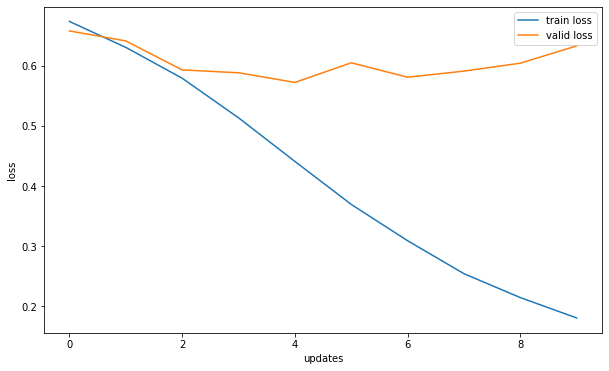

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

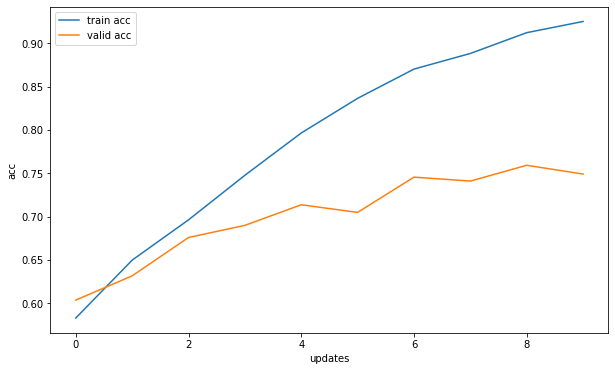

In [18]:
fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

## 4. Evaluation on test set

In [19]:
model.load_state_dict(torch.load('models/DEAP_BiLSTM.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.576 | Test Acc: 71.88%


## Final Verdict



Hmm...so the accuracy is around 70.  Not really impressive.

One quick improvement to LSTM is its speed which takes considerable time to train for each epoch, especially if the seq len is very big.  One way to dramatically increase the speed is to downsize the seq len.  One good way is by applying conv1d+pooling before LSTM.